In [1]:
import numpy as np
import matplotlib.pyplot as plt

with open('binseq.txt', 'r') as f:
    binseq = f.readlines()
binseq = binseq[0].split(',')
binseq[-1] = '1'
binseq = [[float(y) for y in x] for x in binseq]
binseq = np.array(binseq)
binseq = binseq.squeeze()

In [2]:
from prox import prox_dp

import warnings
warnings.filterwarnings('ignore')

generating ./_prox.cpp
(already up-to-date)
the current directory is '/home/lrg1213/Desktop/HW4(III,IV)'
running build_ext
building '_prox' extension
gcc -pthread -B /home/lrg1213/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/lrg1213/anaconda3/include/python3.7m -c _prox.cpp -o ./_prox.o
gcc -pthread -B /home/lrg1213/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/lrg1213/anaconda3/include/python3.7m -c prox.cpp -o ./prox.o
g++ -pthread -shared -B /home/lrg1213/anaconda3/compiler_compat -L/home/lrg1213/anaconda3/lib -Wl,-rpath=/home/lrg1213/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ ./_prox.o ./prox.o -o ./_prox.cpython-37m-x86_64-linux-gnu.so


In [3]:
def g(theta,y):
    return np.sum(-y*theta+np.log(1+np.exp(theta)))

def h(theta,lam):
    return lam*np.sum(np.abs((theta - np.roll(theta,-1))[:-1]))

def gGrad(theta,y):
    return -y+(np.exp(theta)/(1+np.exp(theta)))

def obj(y,theta,lam):
    return g(y,theta)+h(theta,lam)

def Gt(theta,t,y,lam):
    theta_0 = theta.copy()
    prox_dp(n=theta.shape[0], y=theta_0-t*gGrad(theta_0,y), lam=lam*t, theta=theta)
    return (theta_0 - theta)/t

def gd(beta,y):
    return np.sum(np.log(1+np.exp(-y*beta)))
    
def hd(D,beta,lam):
    return lam*np.linalg.norm(np.dot(D,beta),1)
    


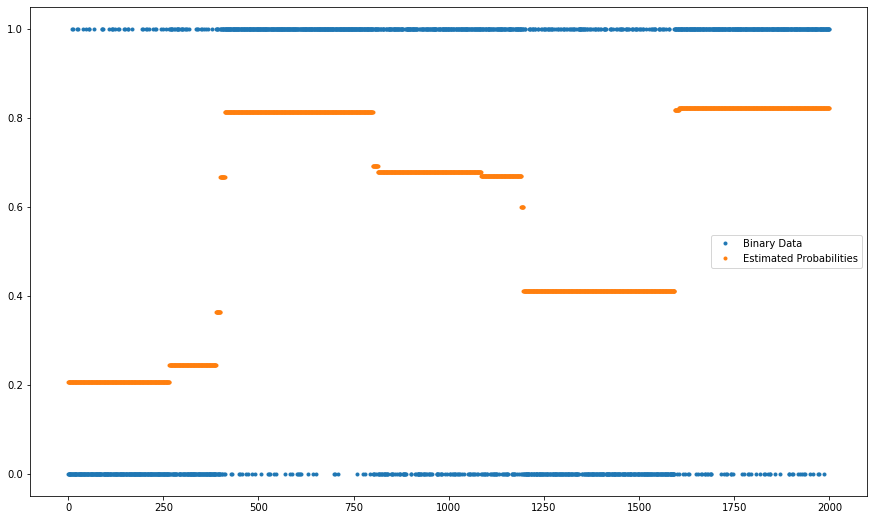

Total iterations: 64


In [4]:

#theta = np.random.randn(*binseq.shape)
theta = np.zeros_like(binseq)
y = binseq.copy()

bta = 0.8
epi = 1e-6
lam = 20
n = binseq.shape[0]
cot = 0

obj_0 = obj(y,theta,lam)
theta_0 = theta.copy()

while(True):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
    if (obj_0 - obj_1) < epi:
         break
    
    obj_0 = obj_1


plt.figure(figsize=(15,9))
plt.plot(binseq,'.',label='Binary Data')
plt.plot((np.exp(theta)/(1+np.exp(theta))),'.',label='Estimated Probabilities')
plt.legend()
plt.show()
print('Total iterations:',cot)
# print(theta)
# print(obj_1)




In [5]:

z = 2*y-1

#Form in 5
print('Loss in (5):',g(theta,y))
print('Penalty in (5):',h(theta,lam))

#Form in 3

Dx = -np.eye(z.shape[0]-1)
Dx = np.insert(Dx, 0, 0, axis=1)
Dx = np.insert(Dx, z.shape[0]-1, 0, axis=0)

D = np.eye(z.shape[0])+Dx
D = np.delete(D,z.shape[0]-1,axis=0)
print('D is :\n',D)

print('Loss in (3):',gd(theta,z))
print('Penalty in (3):',hd(D,theta,lam))

Loss in (5): 983.4964472302881
Penalty in (5): 130.84182101236965
D is :
 [[ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1. -1.]]
Loss in (3): 983.4964472302881
Penalty in (3): 130.84182101236965


In [6]:

from cvxopt import matrix, solvers

lam = 20
delta = 0.01

n = z.shape[0]
m = D.shape[0]
A = (z*D).T
A = np.concatenate((A,-A,np.eye(m),-np.eye(m)))
b1 = (1-delta)*np.ones(n)
b2 = -delta*np.ones(n)
b3 = (lam-delta)*np.ones(m)
b = np.concatenate((b1,b2,b3,b3))
c = np.random.rand(m)

A = matrix(A)
b = matrix(b)
c = matrix(c)

sol=solvers.lp(c,A,b)
u0 = np.array(sol['x'])
u0 = u0.squeeze()

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5791e+00 -1.1937e+05  1e+05  7e-02  5e-16  1e+00
 1: -6.2118e+03 -2.6942e+04  2e+04  1e-02  7e-15  3e-01
 2: -1.1210e+04 -2.6221e+04  2e+04  9e-03  3e-14  5e-01
 3: -1.4915e+04 -2.4361e+04  1e+04  6e-03  2e-14  4e-01
 4: -1.7309e+04 -2.2562e+04  5e+03  3e-03  2e-14  3e-01
 5: -1.8973e+04 -2.1008e+04  2e+03  1e-03  2e-14  1e-01
 6: -1.9469e+04 -2.0490e+04  1e+03  6e-04  1e-14  9e-02
 7: -1.9658e+04 -2.0254e+04  6e+02  4e-04  8e-15  6e-02
 8: -1.9802e+04 -2.0043e+04  2e+02  1e-04  6e-15  3e-02
 9: -1.9831e+04 -1.9989e+04  2e+02  9e-05  8e-14  2e-02
10: -1.9874e+04 -1.9909e+04  4e+01  2e-05  1e-13  4e-03
11: -1.9879e+04 -1.9890e+04  1e+01  6e-06  4e-13  1e-03
12: -1.9881e+04 -1.9883e+04  2e+00  1e-06  4e-13  3e-04
13: -1.9881e+04 -1.9882e+04  5e-01  3e-07  5e-13  7e-05
14: -1.9881e+04 -1.9881e+04  9e-02  5e-08  6e-13  1e-05
15: -1.9881e+04 -1.9881e+04  1e-02  8e-09  8e-13  2e-06
Optimal solution found.


In [7]:
def g1(X):
    return np.sum(X*np.log(X)+(1-X)*np.log(1-X))

def h1(X,u,lam,tau):
    return -tau*(np.sum(np.log(X)+np.log(1-X))+np.sum(np.log(lam-u)+np.log(u+lam)))

def obj1(Dt,u,y,lam,tau):
    X = y*Dt.dot(u)
    return g1(X)+h1(X,u,lam,tau)
    #return h1(Dt,u,y,lam,tau)

def g1Grad(X,D,y):
    G = np.log(X/(1-X))
    return np.asarray(np.sum((D.multiply(G*y)),axis=1)).T.squeeze()
   
def h1Grad(X,D,u,y,lam,tau):
    H1 = np.asarray(np.sum((D.multiply((1/X)*y)-D.multiply((1/(1-X))*y)),axis=1)).T.squeeze()
    H2 = -2*u*(1/(lam-u))*(1/(lam+u))
    return -tau*(H1+H2)

def obj1Grad(Dt,D,u,y,lam,tau):
    X = y*Dt.dot(u)
    return g1Grad(X,D,y)+h1Grad(X,D,u,y,lam,tau)
    
    
def opr(x):
    return np.diag(x[:-1]) + np.diag(x[1:]) + np.diag(-x[1:-1],k=1) + np.diag(-x[1:-1],k=-1)
    
def g2Grad(Dt,y,u):
    return opr((1 / ((y*Dt.dot(u))*(1-y*Dt.dot(u)))))

def h2Grad(Dt,u,y,lam,tau):
    return tau*(2*np.diag((lam**2+u**2) / ((lam**2-u**2)**2)) + opr((1/(Dt.dot(u)))**2 + (1/(1-y*Dt.dot(u)))**2))

def obj2Grad(Dt,u,y,lam,tau):
    return g2Grad(Dt,y,u)+h2Grad(Dt,u,y,lam,tau)
    

In [8]:
# 3.(a)

from time import time
from scipy.sparse import dia_matrix
Ds = dia_matrix(D)
Dts = dia_matrix(D.T)

lam = 20
tau = 1/(1e3)
bta = 0.8
kMax = 50000
epi = 1e-6
alpha = 0.5
u = u0.copy()
#u = np.load("u_5e4.npy")
obj_0 = obj1(Dts,u,z,lam,tau)

for k in range(kMax):
    t = 1
    print('Iteration',k,':')
    print(obj_0)
        
    grad1 = obj1Grad(Dts,Ds,u,z,lam,tau)
    v = np.dot(-np.linalg.inv(obj2Grad(Dts,u,z,lam,tau)),grad1)
    c1 = obj1(Dts,u+t*v,z,lam,tau)
    while(np.isnan(c1)):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
    c2 = obj1(Dts,u,z,lam,tau)
    c3 = np.dot(grad1,v)
    while(c1>c2+alpha*t*c3):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
        
    u = u+t*v
    obj_1 = c1
    if(obj_0-obj_1<epi):
        break
    obj_0 = obj_1

Iteration 0 :
-141.2427165680416
Iteration 1 :
-181.45570246255008
Iteration 2 :
-251.15289153381244
Iteration 3 :
-398.45925517707775
Iteration 4 :
-680.3364700943453
Iteration 5 :
-924.6519286418572
Iteration 6 :
-1006.4939704886915
Iteration 7 :
-1014.2758723601092
Iteration 8 :
-1031.5728661210321
Iteration 9 :
-1038.6178878340115
Iteration 10 :
-1050.1892717755225
Iteration 11 :
-1058.7387830401601
Iteration 12 :
-1074.7676399537324
Iteration 13 :
-1089.1313882162265
Iteration 14 :
-1092.48741235684
Iteration 15 :
-1093.3965235453734
Iteration 16 :
-1102.0753084896237
Iteration 17 :
-1107.4702982934095
Iteration 18 :
-1108.1365376132712
Iteration 19 :
-1113.9151578565682
Iteration 20 :
-1117.8997637292553
Iteration 21 :
-1121.1692786487865
Iteration 22 :
-1121.2917169981815
Iteration 23 :
-1121.2963753879003
Iteration 24 :
-1121.2964053958324
Iteration 25 :
-1121.2964067902124


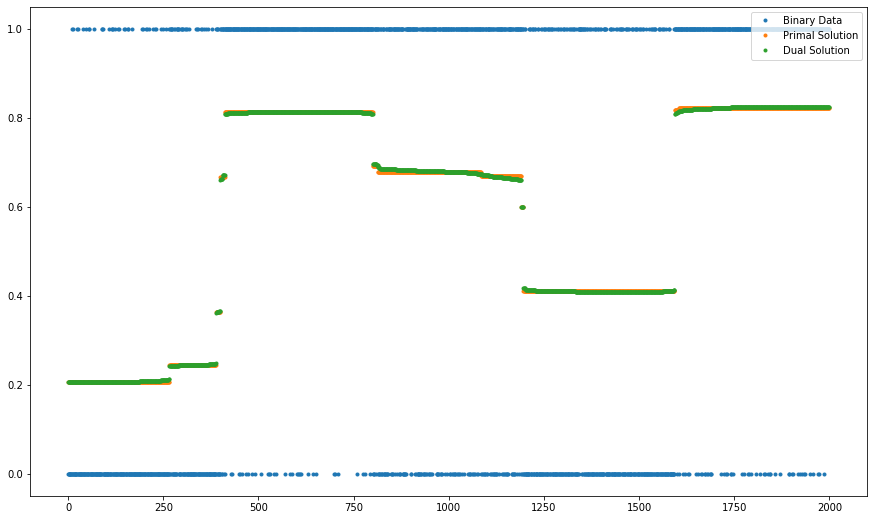

In [9]:
# 4.(d)
X = Dts.dot(u)
beta = -z*np.log(X/(z-X))
plt.figure(figsize=(15,9))
plt.plot(binseq,'.',label='Binary Data')
plt.plot((np.exp(theta)/(1+np.exp(theta))),'.',label='Primal Solution')
plt.plot((np.exp(beta)/(1+np.exp(beta))),'.',label='Dual Solution')
plt.legend(loc='upper right')
plt.show()
# print('Estimated probabilites are closed to those in part(b). ')
# print('Primal Value:',np.sum(np.log(1+np.exp(-z*beta)))+lam*np.linalg.norm(Ds.dot(beta),1))
# print('Primal Value in (b):',gd(theta,z)+hd(D,theta,lam))
# print('Primal Value in (b) is lower.')

In [10]:
# 3.(b)


from cvxopt import matrix, solvers

lam = 20
delta = 0.01

n = z.shape[0]
m = D.shape[0]
A = (z*D).T
A = np.concatenate((A,-A,np.eye(m),-np.eye(m)))
b1 = (1-delta)*np.ones(n)
b2 = -delta*np.ones(n)
b3 = (lam-delta)*np.ones(m)
b = np.concatenate((b1,b2,b3,b3))
c = np.random.rand(m)

A = matrix(A)
b = matrix(b)
c = matrix(c)

sol=solvers.lp(c,A,b)
u0 = np.array(sol['x'])
u0 = u0.squeeze()

y = binseq.copy()
objall = []


bta = 0.8
epi = 0
lam = 20
n = binseq.shape[0]
cot = 0
kMax = 100
theta = np.zeros_like(binseq)
obj_0 = obj(y,theta,lam)

for k in range(kMax):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
#     if (obj_0 - obj_1) < epi:
#          break
    
    obj_0 = obj_1
    objall.append(obj_0)

lam = 20
tau = 1/(1e3)
bta = 0.8
kMax = 100
epi = 0
alpha = 0.5
u = u0.copy()

# X = Dts.dot(u)
# beta = -z*np.log(X/(z-X))
# obj_0 = obj(y,beta,lam)
obj_0 = obj1(Dts,u,z,lam,tau)


for k in range(kMax):
    t = 1
        
    grad1 = obj1Grad(Dts,Ds,u,z,lam,tau)
    v = np.dot(-np.linalg.inv(obj2Grad(Dts,u,z,lam,tau)),grad1)
    c1 = obj1(Dts,u+t*v,z,lam,tau)
    while(np.isnan(c1)):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
    c2 = obj1(Dts,u,z,lam,tau)
    c3 = np.dot(grad1,v)
    while(c1>c2+alpha*t*c3):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
        
    u = u+t*v
    obj_1 = c1
#     if(obj_0-obj_1<epi):
#         break
    obj_0 = obj_1
    
    X = Dts.dot(u)
    beta = -z*np.log(X/(z-X))
    objall.append(obj(y,beta,lam))

f_star = min(objall)-1e-6

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3855e+00 -1.1773e+05  1e+05  7e-02  6e-16  1e+00
 1: -5.7266e+03 -3.7452e+04  3e+04  2e-02  6e-15  5e-01
 2: -1.0239e+04 -3.4015e+04  3e+04  1e-02  1e-14  7e-01
 3: -1.5049e+04 -2.8088e+04  1e+04  8e-03  2e-14  6e-01
 4: -1.7594e+04 -2.4375e+04  7e+03  4e-03  2e-14  4e-01
 5: -1.8996e+04 -2.1873e+04  3e+03  2e-03  1e-14  2e-01
 6: -1.9541e+04 -2.0909e+04  1e+03  8e-04  9e-15  1e-01
 7: -1.9800e+04 -2.0388e+04  6e+02  4e-04  8e-15  6e-02
 8: -1.9908e+04 -2.0180e+04  3e+02  2e-04  1e-14  3e-02
 9: -1.9971e+04 -2.0053e+04  9e+01  5e-05  5e-14  1e-02
10: -1.9988e+04 -2.0005e+04  2e+01  1e-05  2e-13  2e-03
11: -1.9991e+04 -1.9996e+04  5e+00  3e-06  4e-13  7e-04
12: -1.9992e+04 -1.9993e+04  1e+00  6e-07  5e-13  1e-04
13: -1.9992e+04 -1.9992e+04  2e-01  1e-07  6e-13  3e-05
14: -1.9992e+04 -1.9992e+04  2e-02  1e-08  7e-13  2e-06
Optimal solution found.


In [11]:
y = binseq.copy()
gap_prox = []

bta = 0.8
epi = 0
lam = 20
n = binseq.shape[0]
cot = 0
kMax = 100
theta = np.zeros_like(binseq)
obj_0 = obj(y,theta,lam)

for k in range(kMax):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
#     if (obj_0 - obj_1) < epi:
#          break
    
    obj_0 = obj_1
    gap_prox.append(obj_0-f_star)

lam = 20
tau = 1/(1e3)
bta = 0.8
kMax = 100
epi = 0
alpha = 0.5
u = u0.copy()
obj_0 = obj1(Dts,u,z,lam,tau)

gap_newton=[]

for k in range(kMax):
    t = 1
        
    grad1 = obj1Grad(Dts,Ds,u,z,lam,tau)
    v = np.dot(-np.linalg.inv(obj2Grad(Dts,u,z,lam,tau)),grad1)
    c1 = obj1(Dts,u+t*v,z,lam,tau)
    while(np.isnan(c1)):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
    c2 = obj1(Dts,u,z,lam,tau)
    c3 = np.dot(grad1,v)
    while(c1>c2+alpha*t*c3):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
        
    u = u+t*v
    obj_1 = c1
#     if(obj_0-obj_1<epi):
#         break
    obj_0 = obj_1
    X = Dts.dot(u)
    beta = -z*np.log(X/(z-X))
    gap_newton.append(obj(y,beta,lam)-f_star)
    

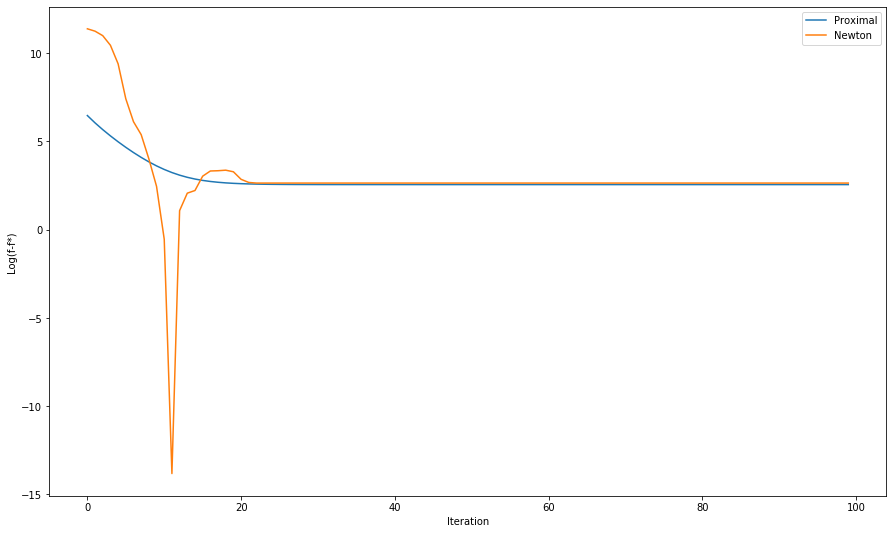

In [12]:
plt.figure(figsize=(15,9))
plt.plot(np.log(gap_prox),label='Proximal')
plt.plot(np.log(gap_newton),label='Newton')
plt.xlabel('Iteration')
plt.ylabel('Log(f-f*)')
plt.legend(loc='upper right')
plt.show()

In [13]:
from cvxopt import matrix, solvers

lam = 0.02
delta = 1e-8

n = z.shape[0]
m = D.shape[0]
A = (z*D).T
A = np.concatenate((A,-A,np.eye(m),-np.eye(m)))
b1 = (1-delta)*np.ones(n)
b2 = -delta*np.ones(n)
b3 = (lam-delta)*np.ones(m)
b = np.concatenate((b1,b2,b3,b3))
c = np.random.rand(m)

A = matrix(A)
b = matrix(b)
c = matrix(c)

sol=solvers.lp(c,A,b)
u0 = np.array(sol['x'])
u0 = u0.squeeze()

#theta = np.random.randn(*binseq.shape)
#theta_0 = theta.copy()
theta = np.zeros_like(binseq)
y = binseq.copy()

bta = 0.8
epi = 0
lam = 0.02
n = binseq.shape[0]
cot = 0
kMax = 100
obj_0 = obj(y,theta,lam)
objall = []

for k in range(kMax):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
#     if (obj_0 - obj_1) < epi:
#          break
    
    obj_0 = obj_1
    objall.append(obj_0)

from scipy.sparse import dia_matrix
Ds = dia_matrix(D)
Dts = dia_matrix(D.T)

lam = 0.02
tau = 1/(1e3)
bta = 0.8
kMax = 100
epi = 0
alpha = 0.5
u = u0.copy()
obj_0 = obj1(Dts,u,z,lam,tau)

for k in range(kMax):
    t = 1
        
    grad1 = obj1Grad(Dts,Ds,u,z,lam,tau)
    v = np.dot(-np.linalg.inv(obj2Grad(Dts,u,z,lam,tau)),grad1)
    c1 = obj1(Dts,u+t*v,z,lam,tau)
    while(np.isnan(c1)):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
    c2 = obj1(Dts,u,z,lam,tau)
    c3 = np.dot(grad1,v)
    while(c1>c2+alpha*t*c3):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
        
    u = u+t*v
    obj_1 = c1
#     if(obj_0-obj_1<epi):
#         break
    obj_0 = obj_1
    X = Dts.dot(u)
    beta = -z*np.log(X/(z-X))
    objall.append(obj(y,beta,lam))

f_star = min(objall)-1e-6


     pcost       dcost       gap    pres   dres   k/t
 0: -5.2009e+00 -2.9989e+03  2e+04  3e+00  5e-16  1e+00
 1:  4.2231e+01 -4.8241e+02  2e+03  5e-01  7e-16  1e+00
 2: -8.3756e+00 -5.9666e+01  1e+02  5e-02  6e-16  1e-01
 3: -1.5435e+01 -3.7297e+01  4e+01  2e-02  5e-16  5e-02
 4: -1.8569e+01 -3.0769e+01  2e+01  1e-02  4e-16  2e-02
 5: -1.9459e+01 -2.3062e+01  7e+00  3e-03  3e-16  5e-03
 6: -1.9782e+01 -2.0686e+01  2e+00  9e-04  3e-16  6e-04
 7: -1.9835e+01 -2.0046e+01  4e-01  2e-04  3e-16  1e-04
 8: -1.9848e+01 -1.9900e+01  9e-02  5e-05  3e-16  2e-05
 9: -1.9852e+01 -1.9857e+01  8e-03  4e-06  4e-16  1e-06
10: -1.9853e+01 -1.9853e+01  1e-04  7e-08  5e-15  2e-08
11: -1.9853e+01 -1.9853e+01  5e-05  2e-08  2e-11  7e-09
12: -1.9853e+01 -1.9853e+01  6e-05  3e-08  4e-10  8e-09
13: -1.9853e+01 -1.9853e+01  7e-05  2e-08  7e-10  9e-09
14: -1.9853e+01 -1.9853e+01  7e-05  2e-08  7e-10  8e-09
15: -1.9853e+01 -1.9853e+01  6e-05  2e-08  7e-10  7e-09
16: -1.9853e+01 -1.9853e+01  4e-05  1e-08  1e-09  

In [14]:
y = binseq.copy()
gap_prox = []


bta = 0.8
epi = 0
lam = 0.02
n = binseq.shape[0]
cot = 0
kMax = 100
theta = np.zeros_like(binseq)
obj_0 = obj(y,theta,lam)

for k in range(kMax):
    t = 1
    G = Gt(theta,t,y,lam)
    while (g(theta-t*G,y) > g(theta,y)-t*np.dot(gGrad(theta,y),G)+0.5*t*(np.linalg.norm(G)**2)):
        t = bta*t
        cot = cot+1
        G = Gt(theta,t,y,lam)
    cot = cot+1
    prox_dp(n=n, y=theta-t*gGrad(theta,y), lam=lam*t, theta=theta)
    obj_1 = obj(y,theta,lam)
    
#     if (obj_0 - obj_1) < epi:
#          break
    
    obj_0 = obj_1
    gap_prox.append(obj_0-f_star)

lam = 0.02
tau = 1/(1e3)
bta = 0.8
kMax = 100
epi = 0
alpha = 0.5
u = u0.copy()
obj_0 = obj1(Dts,u,z,lam,tau)

gap_newton=[]

for k in range(kMax):
    t = 1
        
    grad1 = obj1Grad(Dts,Ds,u,z,lam,tau)
    v = np.dot(-np.linalg.inv(obj2Grad(Dts,u,z,lam,tau)),grad1)
    c1 = obj1(Dts,u+t*v,z,lam,tau)
    while(np.isnan(c1)):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
    c2 = obj1(Dts,u,z,lam,tau)
    c3 = np.dot(grad1,v)
    while(c1>c2+alpha*t*c3):
        t = bta*t
        c1 = obj1(Dts,u+t*v,z,lam,tau)
        
    u = u+t*v
    obj_1 = c1
#     if(obj_0-obj_1<epi):
#         break
    obj_0 = obj_1
    X = Dts.dot(u)
    beta = -z*np.log(X/(z-X))
    gap_newton.append(obj(y,beta,lam)-f_star)
    



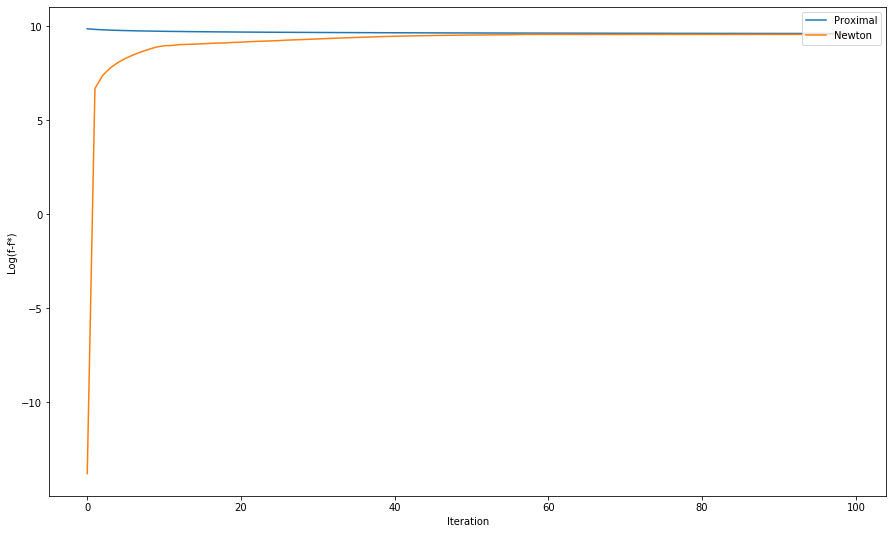

In [15]:
plt.figure(figsize=(15,9))
plt.plot(np.log(gap_prox),label='Proximal')
plt.plot(np.log(gap_newton),label='Newton')
plt.xlabel('Iteration')
plt.ylabel('Log(f-f*)')
plt.legend(loc='upper right')
plt.show()